#  Lab 5: Customer Segmentation (Clustering)
This lab demonstrates customer segmentation using clustering algorithms such as **K-Means** and **DBSCAN**.

**Workflow:** EDA → Preprocessing → Model Selection → Evaluation → Interpretation → Deployment Sketch.

In [21]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import joblib, warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (7,5)


## 1. Dataset Generation
We simulate a realistic customer dataset for segmentation analysis.

In [22]:

np.random.seed(42)
n = 1000

gender = np.random.choice(['Male', 'Female'], n, p=[0.5, 0.5])
age = np.random.normal(35, 10, n).clip(18, 70)
income = np.random.normal(60, 25, n).clip(10, 150)
spending = np.random.normal(50, 25, n).clip(1, 100)
savings = np.random.normal(30, 15, n).clip(1, 100)
online = np.random.normal(50, 20, n).clip(1, 100)

# Relationship: higher income = higher savings, moderate spending
spending += (income - 60) * 0.2
spending = np.clip(spending, 1, 100)

df = pd.DataFrame({
    'Gender': gender,
    'Customer_Age': age.round(0),
    'Annual_Income_kUSD': income.round(1),
    'Spending_Score': spending.round(1),
    'Savings_kUSD': savings.round(1),
    'Online_Shopping_Score': online.round(1)
})

df.to_csv('customer_segmentation.csv', index=False)
print(' Dataset created and saved as customer_segmentation.csv')
df.head()

df = pd.read_csv('customer_segmentation.csv')
df.head()

 Dataset created and saved as customer_segmentation.csv


,Gender,Customer_Age,Annual_Income_kUSD,Spending_Score,Savings_kUSD,Online_Shopping_Score
0,Male,37.0,24.8,64.8,27.7,55.6
1,Female,22.0,57.9,33.3,25.1,55.8
2,Female,39.0,22.4,12.4,14.4,16.2
3,Female,41.0,79.0,27.7,12.4,30.4
4,Male,41.0,62.1,38.2,37.0,100.0


## 2. Exploratory Data Analysis (EDA)
We explore data structure, distributions, and relationships between features.

,Customer_Age,Annual_Income_kUSD,Spending_Score,Savings_kUSD,Online_Shopping_Score
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,36.135000,60.519600,49.863200,29.276000,49.370600
std,9.553326,23.839993,25.123322,14.173209,19.489704
min,18.000000,10.000000,1.000000,1.000000,1.000000
25%,29.000000,43.950000,32.275000,19.475000,36.750000
50%,36.000000,60.300000,49.550000,29.550000,49.150000
75%,42.000000,76.625000,67.050000,38.900000,62.500000
max,67.000000,138.400000,100.000000,77.300000,100.000000


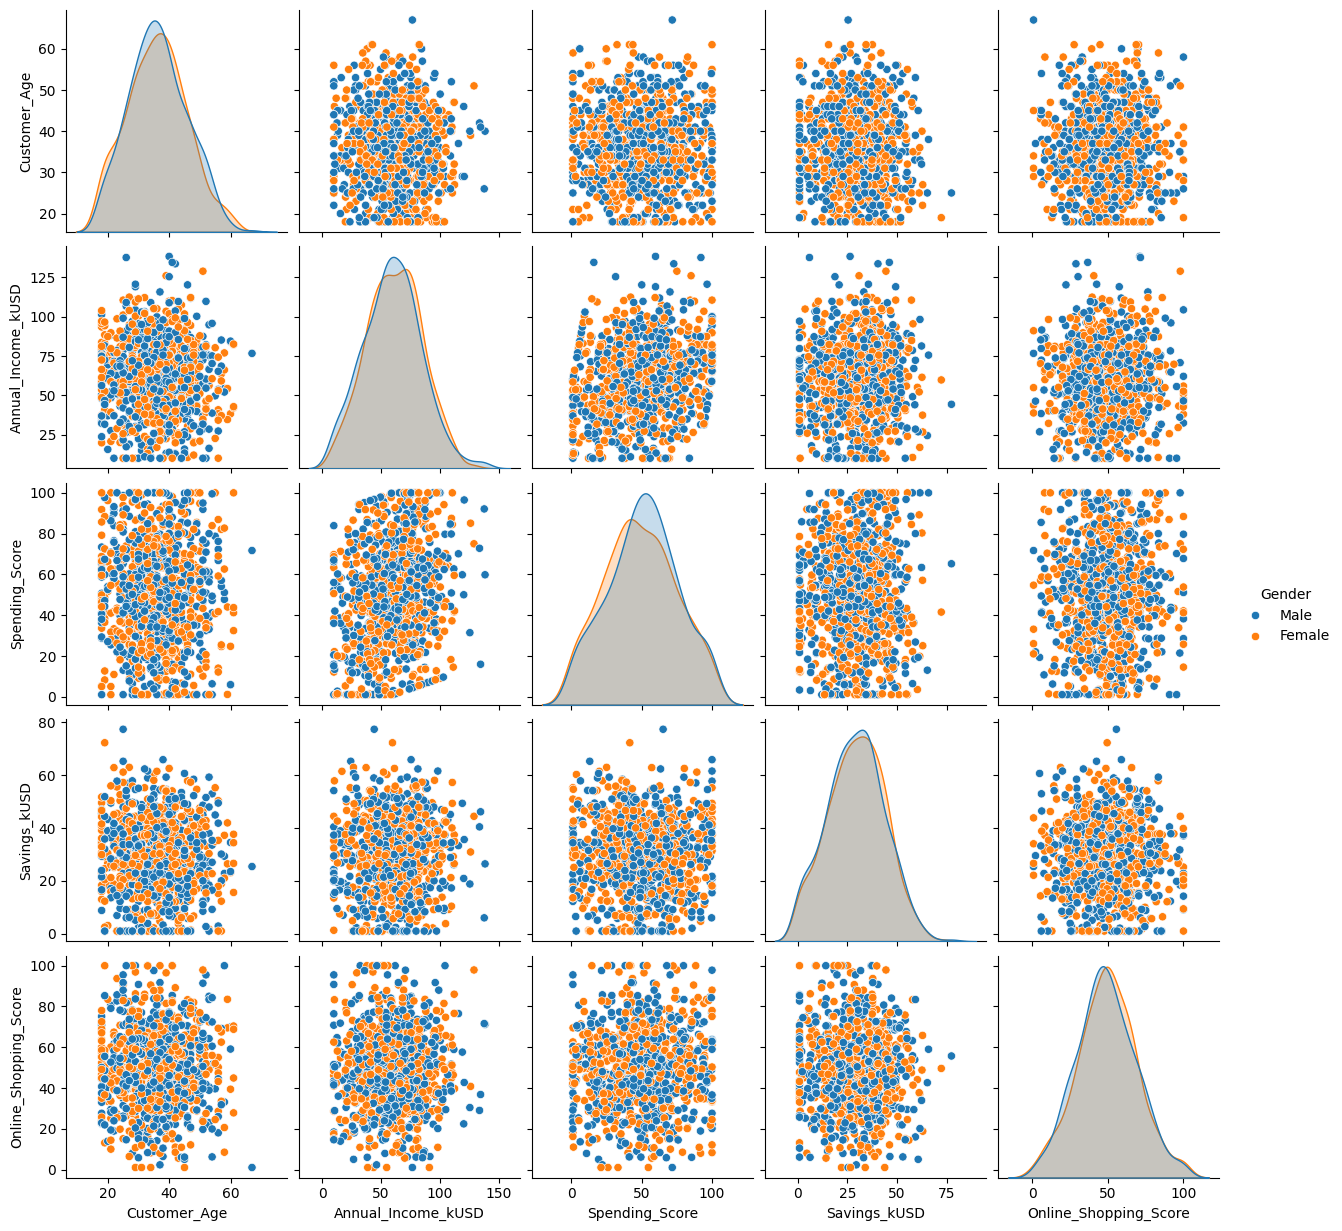

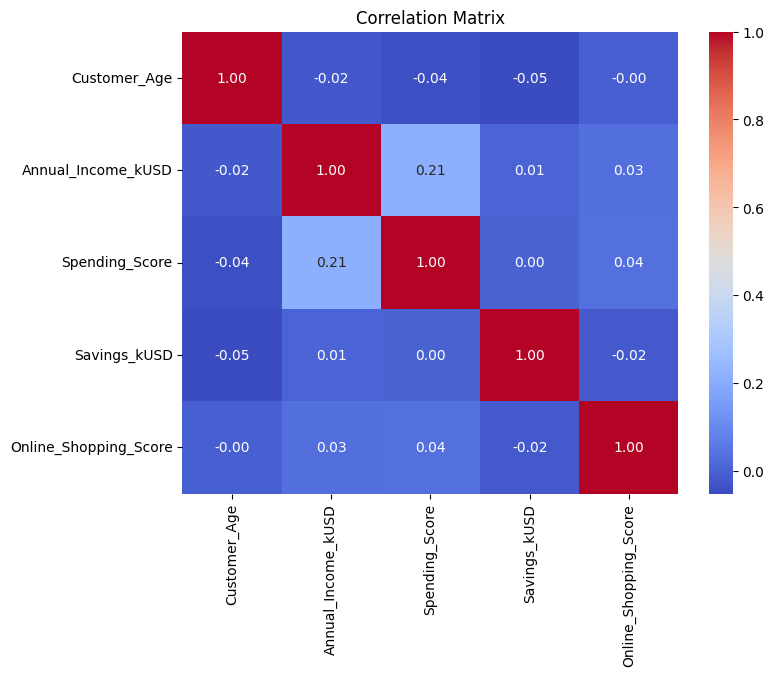

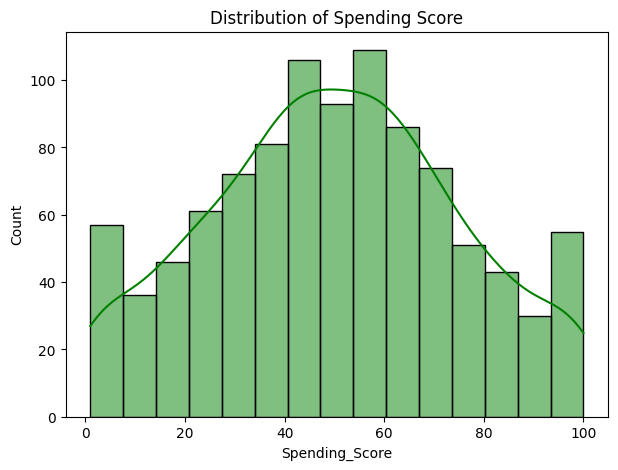

In [23]:

display(df.describe())

# Safe pairplot
if 'Gender' in df.columns:
    sns.pairplot(df, hue='Gender')
else:
    sns.pairplot(df)
plt.show()

# Correlation matrix
plt.figure(figsize=(8,6))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Distribution of Spending Score
if 'Spending_Score' in df.columns:
    sns.histplot(df['Spending_Score'], kde=True, color='green')
    plt.title('Distribution of Spending Score')
    plt.show()
else:
    print(" Column 'Spending_Score' not found.")


## 3. Preprocessing
We encode categorical variables and scale numerical features for clustering.

In [24]:

le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

df_scaled = pd.DataFrame(scaled_data, columns=df.columns)
print(' Data encoded and scaled successfully.')
df_scaled.head()


 Data encoded and scaled successfully.


,Gender,Customer_Age,Annual_Income_kUSD,Spending_Score,Savings_kUSD,Online_Shopping_Score
0,0.994018,0.090590,-1.499056,0.594837,-0.111251,0.319785
1,-1.006018,-1.480330,-0.109938,-0.659606,-0.294788,0.330052
2,-1.006018,0.300046,-1.599777,-1.491918,-1.050111,-1.702807
3,-1.006018,0.509502,0.775573,-0.882618,-1.191293,-0.973852
4,0.994018,0.509502,0.066325,-0.464470,0.545245,2.599051


## 4. Model Selection - K-Means
We determine optimal number of clusters using Elbow and Silhouette methods.

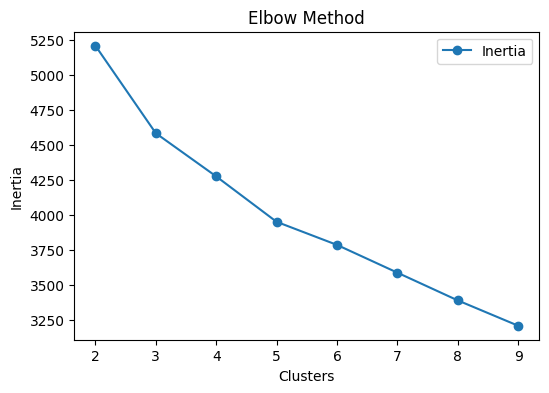

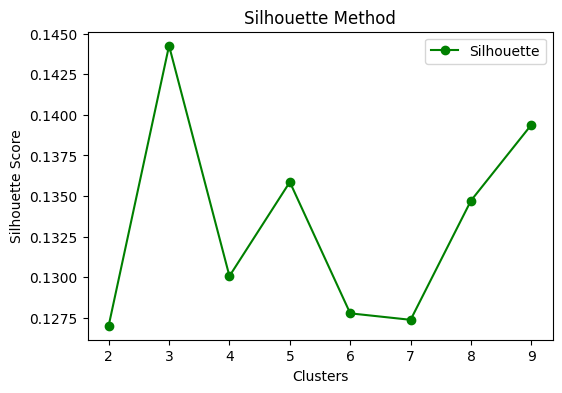

In [25]:

inertia = []
silhouette = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(df_scaled, kmeans.labels_))

# Elbow method
plt.figure(figsize=(6,4))
plt.plot(range(2,10), inertia, 'o-', label='Inertia')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.legend()
plt.show()

# Silhouette method
plt.figure(figsize=(6,4))
plt.plot(range(2,10), silhouette, 'o-', color='green', label='Silhouette')
plt.xlabel('Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.legend()
plt.show()


## 5. Final K-Means Model
We select the best k based on metrics and interpret cluster profiles.

In [26]:

optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans_final.fit_predict(df_scaled)
df['Cluster'] = clusters

print(f' Final model trained with k={optimal_k}')
display(df.groupby('Cluster').mean())


 Final model trained with k=4


,Gender,Customer_Age,Annual_Income_kUSD,Spending_Score,Savings_kUSD,Online_Shopping_Score
Cluster,,,,,,
0,0.574074,39.569444,36.163426,23.406481,29.252315,44.865741
1,0.000000,34.874372,64.626633,54.215075,37.483920,62.901508
2,0.009615,35.129808,69.758654,55.907212,20.943750,39.288462
3,1.000000,35.387268,67.209019,59.389655,29.554111,50.371883


## 6. Cluster Visualization (PCA)
We visualize clusters in 2D using Principal Component Analysis.

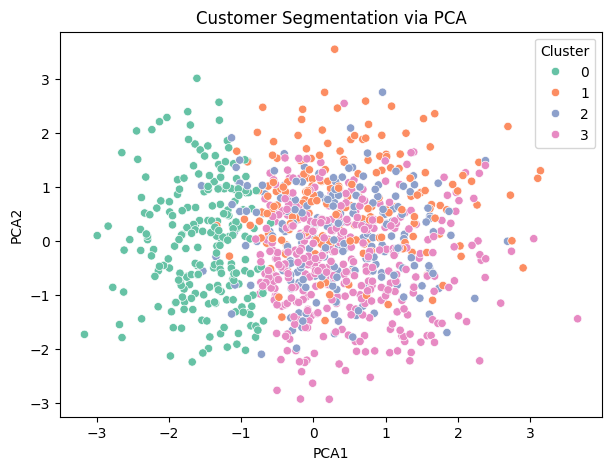

In [27]:

pca = PCA(n_components=2)
reduced = pca.fit_transform(df_scaled)
df['PCA1'], df['PCA2'] = reduced[:,0], reduced[:,1]

sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.title('Customer Segmentation via PCA')
plt.show()


## 7. Alternative Model: DBSCAN
We apply DBSCAN for density-based clustering and anomaly detection.

DBSCAN identified 3 clusters (excluding noise)


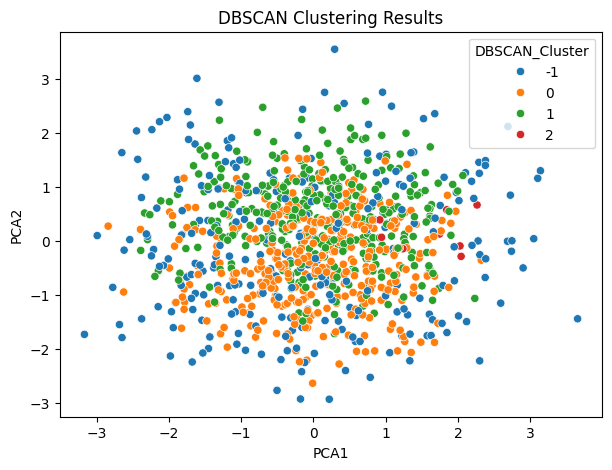

In [28]:

dbscan = DBSCAN(eps=1.2, min_samples=10)
labels = dbscan.fit_predict(df_scaled)

df['DBSCAN_Cluster'] = labels
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f'DBSCAN identified {n_clusters} clusters (excluding noise)')

sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='DBSCAN_Cluster', palette='tab10')
plt.title('DBSCAN Clustering Results')
plt.show()


## 8. Evaluation and Interpretation
We analyze and visualize cluster-level statistics.

Cluster Profile Summary:


,Customer_Age,Annual_Income_kUSD,Spending_Score,Savings_kUSD,Online_Shopping_Score
Cluster,,,,,
0,39.6,36.2,23.4,29.3,44.9
1,34.9,64.6,54.2,37.5,62.9
2,35.1,69.8,55.9,20.9,39.3
3,35.4,67.2,59.4,29.6,50.4


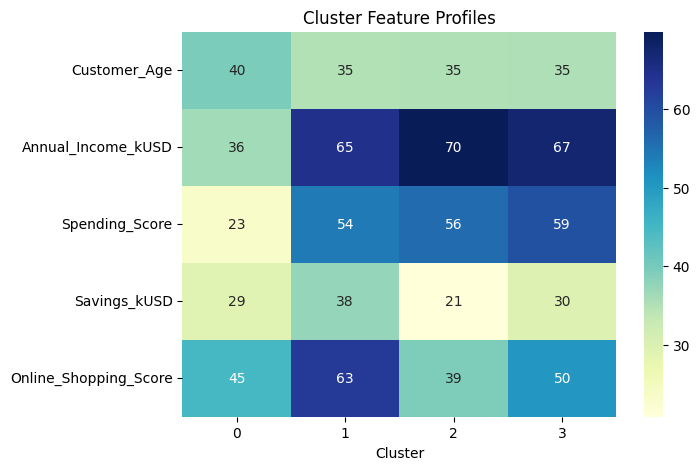

In [29]:

profile = df.groupby('Cluster')[['Customer_Age','Annual_Income_kUSD','Spending_Score',
                                'Savings_kUSD','Online_Shopping_Score']].mean().round(1)
print('Cluster Profile Summary:')
display(profile)

sns.heatmap(profile.T, cmap='YlGnBu', annot=True)
plt.title('Cluster Feature Profiles')
plt.show()


## 9. Deployment Sketch
Save the trained K-Means model and scaler, then predict cluster for new customers.

In [30]:

joblib.dump(kmeans_final, 'customer_segmentation_model.joblib')
joblib.dump(scaler, 'customer_segmentation_scaler.joblib')
print(' Model and scaler saved successfully!')

# Predict clusters for new customers
new_customers = pd.DataFrame({
    'Gender': [1, 0],
    'Customer_Age': [25, 45],
    'Annual_Income_kUSD': [85, 40],
    'Spending_Score': [90, 35],
    'Savings_kUSD': [15, 55],
    'Online_Shopping_Score': [80, 50]
})

scaled_new = scaler.transform(new_customers)
pred_clusters = kmeans_final.predict(scaled_new)
new_customers['Predicted_Cluster'] = pred_clusters

print('New Customer Cluster Predictions:')
display(new_customers)


 Model and scaler saved successfully!
New Customer Cluster Predictions:


,Gender,Customer_Age,Annual_Income_kUSD,Spending_Score,Savings_kUSD,Online_Shopping_Score,Predicted_Cluster
0,1,25,85,90,15,80,3
1,0,45,40,35,55,50,1


###  Summary
- Generated realistic customer data
- Conducted safe EDA with pairplots and correlations
- Built and evaluated K-Means and DBSCAN models
- Visualized clusters using PCA
- Saved deployable clustering model
- Predicted clusters for new customers